In [4]:
from __future__ import division, print_function
%matplotlib inline

# Tutorial 2: Feature detection

This tutorial was adapted from https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/2_feature_detection.ipynb.

Feature detection is often the end result of image processing. We'll detect some basic features (edges, points, and circles) in this section, but there are a wealth of feature detectors that are available.

## Edge detection

Before we start, let's set the default colormap to grayscale and turn off pixel interpolation.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

We've already discussed edge filtering, using the Sobel filter, in the last section.

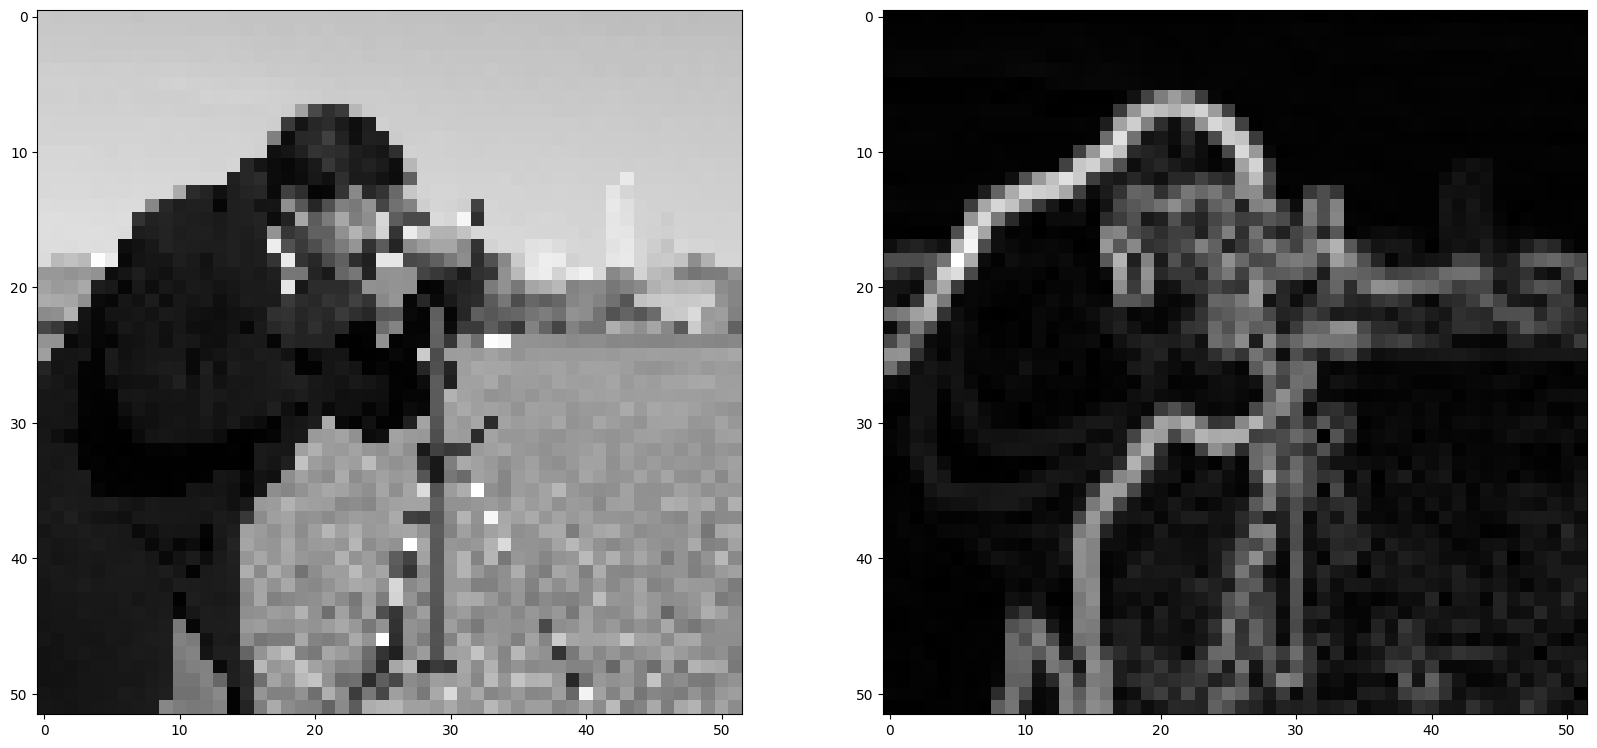

In [6]:
from skimage import data
from skimage import filters

image = data.camera()
pixelated = image[::10, ::10]
gradient = filters.sobel(pixelated)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(pixelated)
ax[1].imshow(gradient)

With the Sobel filter, however, we get back a grayscale image, which essentially tells us the likelihood that a pixel is on the edge of an object.

We can apply a bit more logic to *detect* an edge; i.e. we can use that filtered image to make a *decision* whether or not a pixel is on an edge. The simplest way to do that is with thresholding:

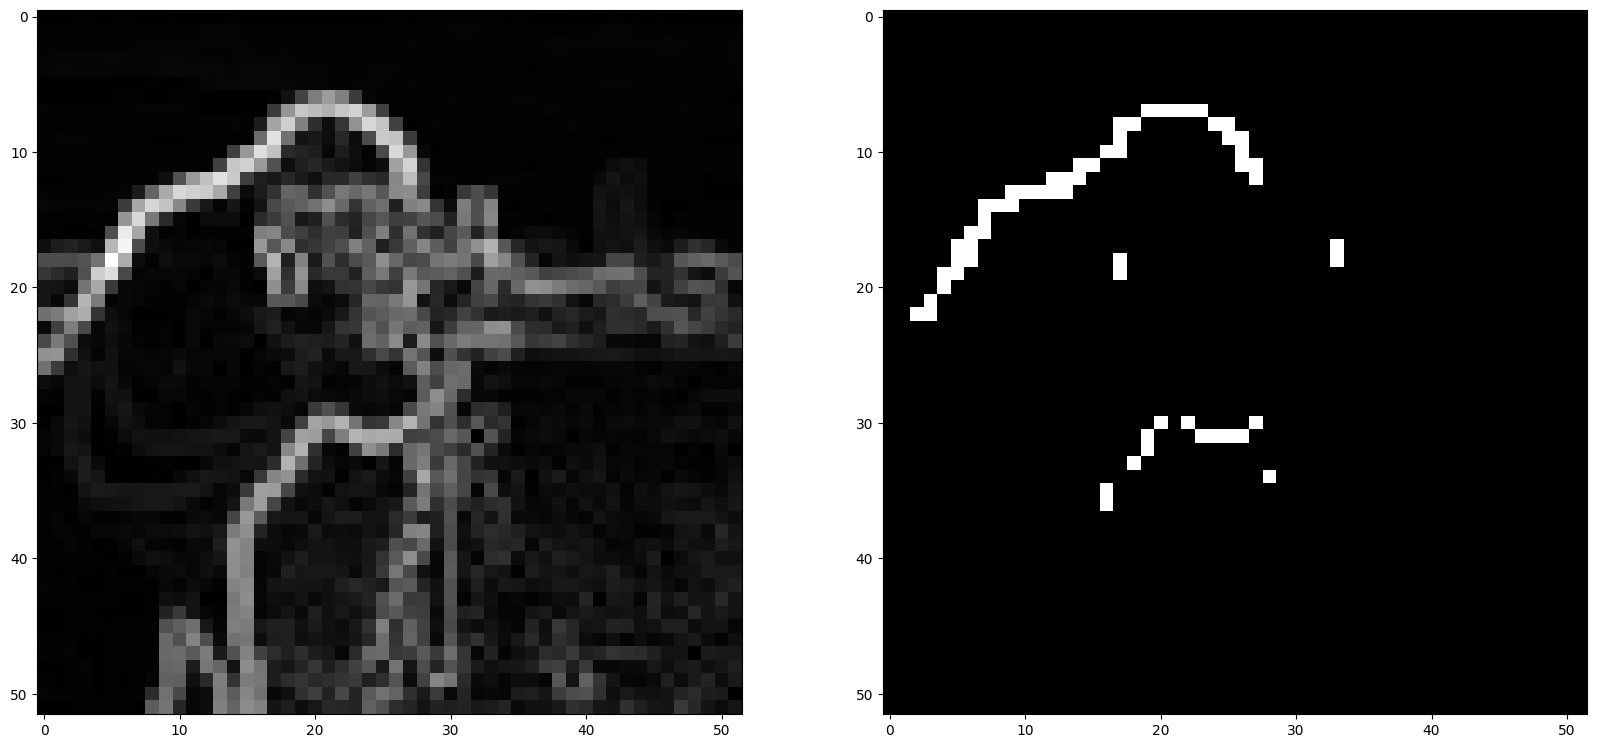

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(gradient)
ax[1].imshow(gradient > 0.4)

That approach doesn't do a great job. It's noisy and produces thick edges. Furthermore, it doesn't use our *knowledge* of how edges work: They should be thin and tend to be connected along the direction of the edge.

## Canny edge detector

The Canny edge detector combines the Sobel filter with a few other steps to give a binary edge image. The steps are as follows:
* Gaussian filter
* Sobel filter
* Non-maximal suppression
* Hysteresis thresholding

Let's go through these steps one at a time.

### Step 1: Gaussian filter

As discussed earlier, gradients tend to enhance noise. To combat this effect, we first smooth the image using a gradient filter:

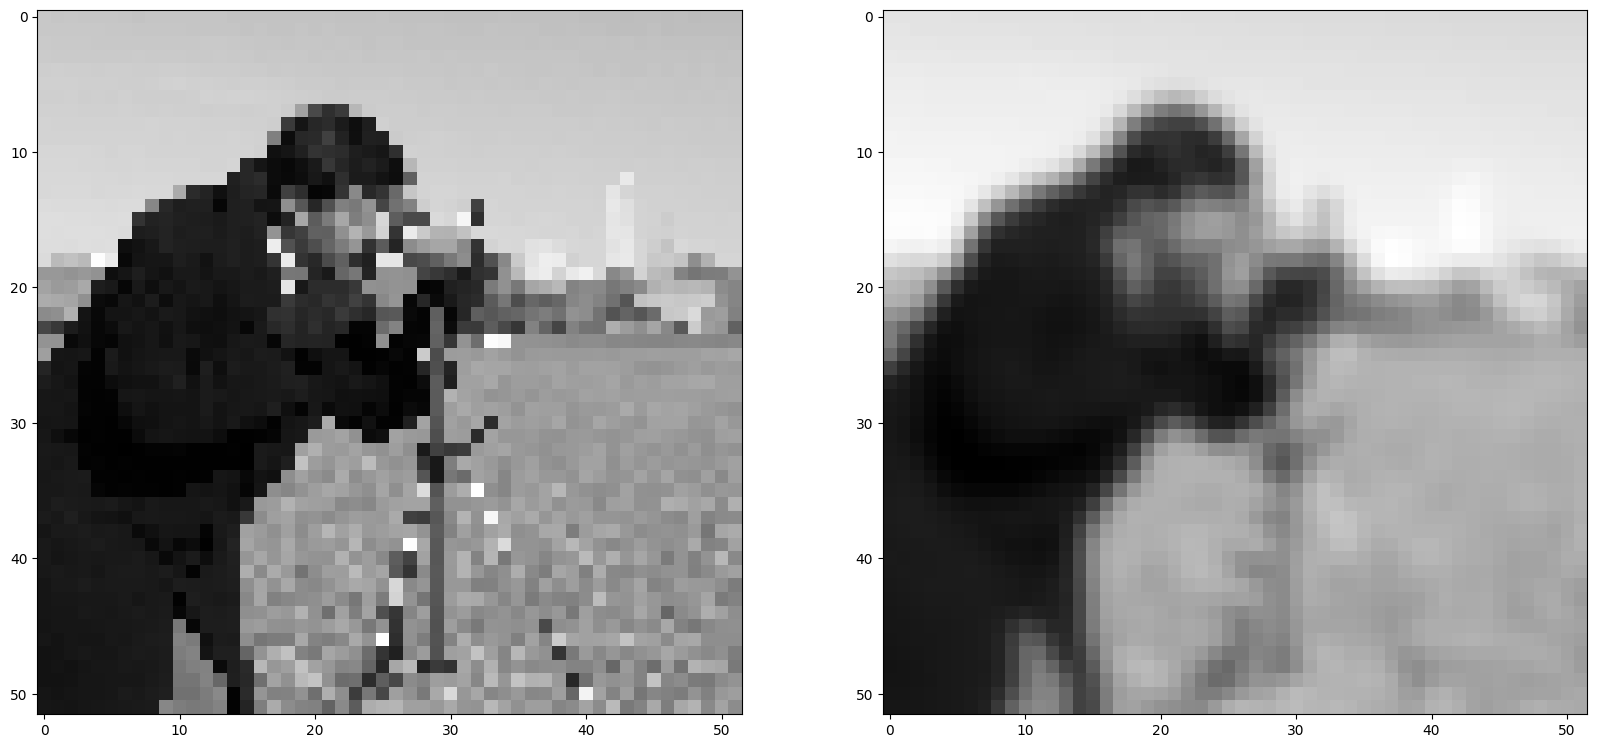

In [8]:
from skimage import img_as_float

sigma = 1  # Standard-deviation of Gaussian; larger smooths more.
pixelated_float = img_as_float(pixelated)
pixelated_float = pixelated
smooth = filters.gaussian(pixelated_float, sigma)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(pixelated_float)
ax[1].imshow(smooth)

### Step 2: Sobel filter

Next, we apply our edge filter:

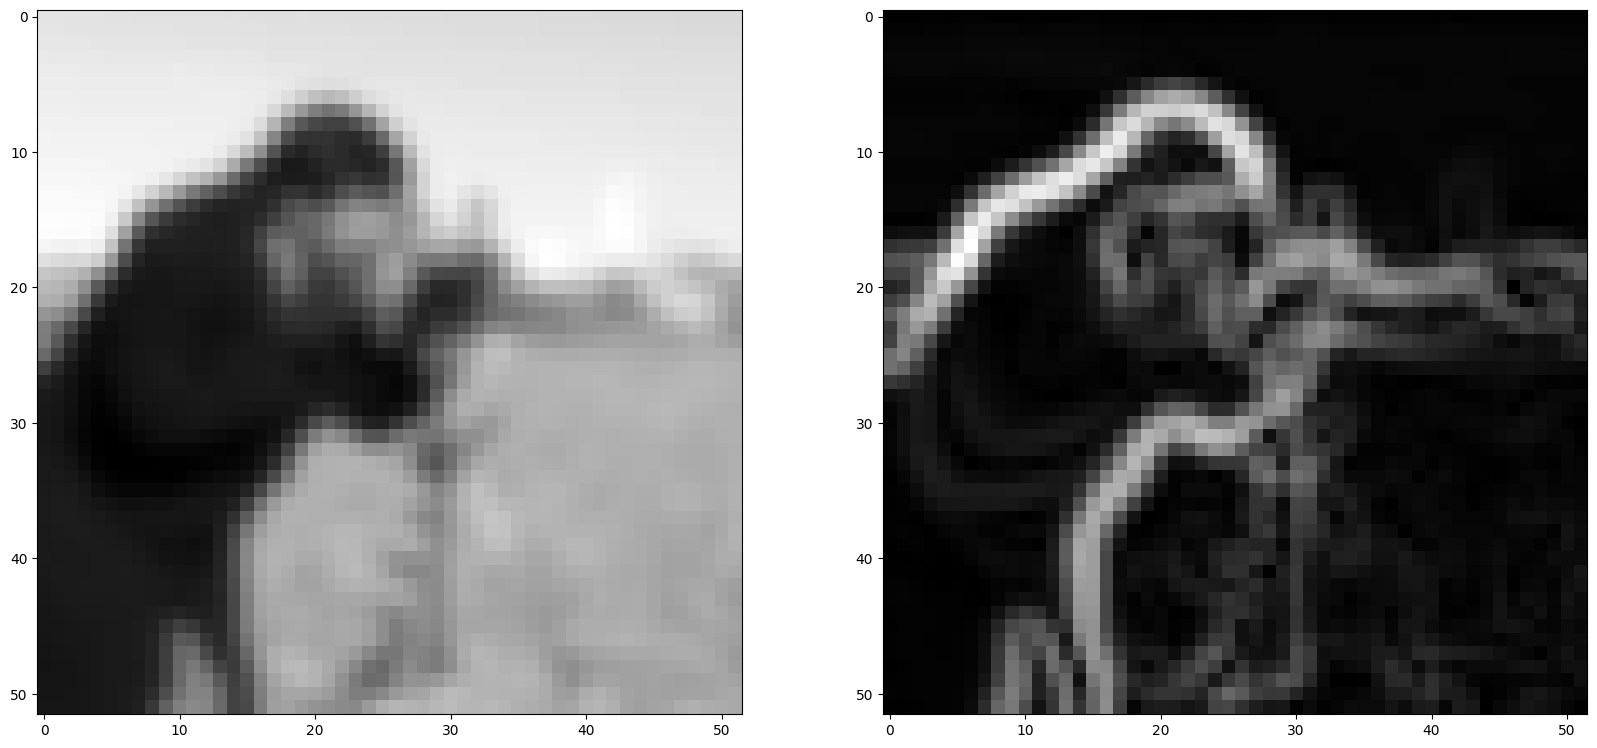

In [9]:
gradient_magnitude = filters.sobel(smooth)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(smooth)
ax[1].imshow(gradient_magnitude)

### Step 3: Non-maximal suppression

Goal: Suppress gradients that aren't on an edge

Ideally, an edge is thin: In some sense, an edge is infinitely thin, but images are discrete so we want edges to be a single pixel wide. To accomplish this, we thin the image using "non-maximal suppression". This takes the edge-filtered image and thins the response *across* the edge direction; i.e. in the direction of the maximum gradient:

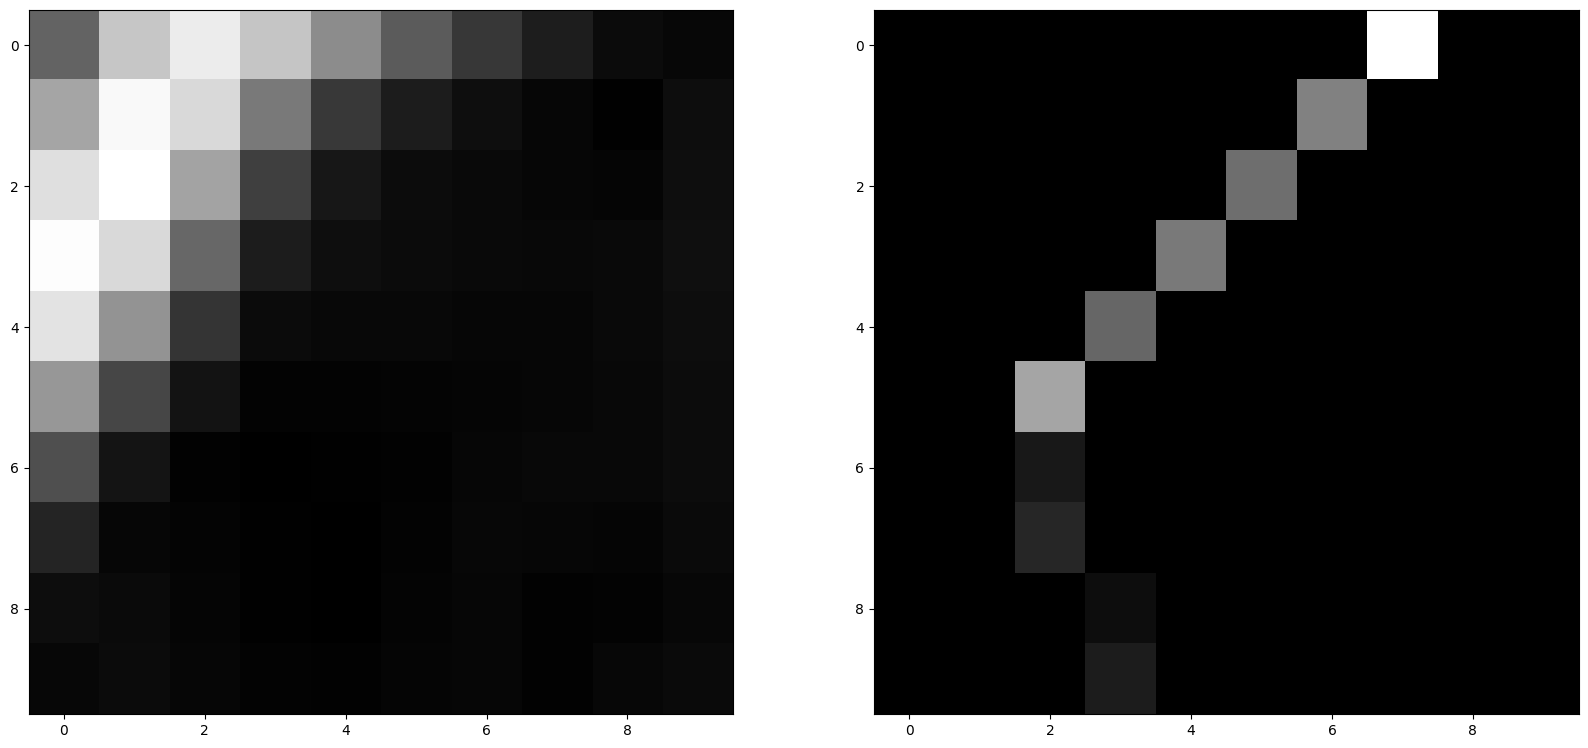

In [10]:
zoomed_grad = gradient_magnitude[15:25, 5:15]
maximal_mask = np.zeros_like(zoomed_grad)
# This mask is made up for demo purposes
maximal_mask[range(10), (7, 6, 5, 4, 3, 2, 2, 2, 3, 3)] = 1
grad_along_edge = maximal_mask * zoomed_grad
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(zoomed_grad)
ax[1].imshow(grad_along_edge)

Obviously, this is a faked version of non-maximal suppression: Pixels are *manually* masked here. The actual algorithm detects the direction of edges, and keeps a pixel only if it has a locally maximal gradient-magnitude in the direction *normal to the edge direction*. It doesn't mask pixels *along* the edge direction since an adjacent edge pixel will be of comparable magnitude.

The result of the filter is that an edge is only possible if there are no better edges near it.

### Step 4: Hysteresis thresholding

Goal: Prefer pixels that are connected to edges

The final step is the actual decision-making process. Here, we have two parameters: The low threshold and the high threshold. The high threshold sets the gradient value that you *know* is definitely an edge. The low threshold sets the gradient value that could be an edge, but only if it's connected to a pixel that we know is an edge.

These two thresholds are displayed below:

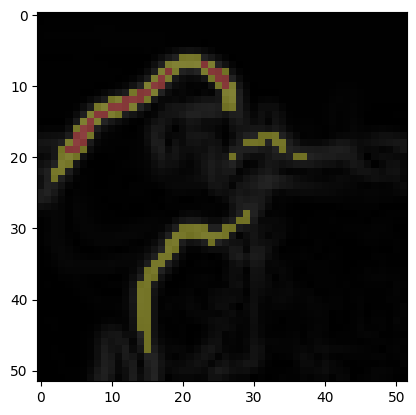

In [11]:
from skimage import color

low_threshold = 0.2
high_threshold = 0.3
label_image = np.zeros_like(pixelated)
# This uses `gradient_magnitude` which has NOT gone through non-maximal-suppression.
label_image[gradient_magnitude > low_threshold] = 1
label_image[gradient_magnitude > high_threshold] = 2
demo_image = color.label2rgb(label_image, gradient_magnitude,
                             bg_label=0, colors=('yellow', 'red'))
plt.imshow(demo_image)

The **red points** here are above `high_threshold` and are seed points for edges. The **yellow points** are edges if connected (possibly by other yellow points) to seed points; i.e. isolated groups of yellow points will not be detected as edges.

Note that the demo above is on the edge image *before* non-maximal suppression, but in reality, this would be done on the image *after* non-maximal suppression. There isn't currently an easy way to get at the intermediate result.

### All-in-one: The Canny edge detector

Now we're ready to look at the actual result:

In [12]:
canny_edge = feature.canny(pixelated)
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(pixelated)
ax[1].imshow(canny_edge)

NameError: name 'feature' is not defined

## Hough transforms

Hough transforms are a general class of operations that make up a step in feature detection. Just like we saw with edge detection, Hough transforms produce a result that we can use to detect a feature. (The distinction between the "filter" that we used for edge detection and the "transform" that we use here is a bit arbitrary.)

### Circle detection

To explore the Hough transform, let's take the *circular* Hough transform as our example. Let's grab an image with some circles:

In [ ]:
image = data.coins()[0:95, 180:370]
plt.imshow(image);

We can use the Canny edge filter to get a pretty good representation of these circles:

In [ ]:
edges = feature.canny(image, sigma=3, low_threshold=10, high_threshold=60)
plt.imshow(edges);

While it looks like we've extracted circles, this doesn't give us much if what we want to do is *measure* these circles. For example, what are the size and position of the circles in the above image? The edge image doesn't really tell us much about that.

We'll use the Hough transform to extract circle positions and radii:

In [ ]:
from skimage.transform import hough_circle
 
hough_radii = np.arange(15, 30, 2)
hough_response = hough_circle(edges, hough_radii)

Here, the circular Hough transform actually uses the edge image from before. We also have to define the radii that we want to search for in our image.

So... what's the actual result that we get back?

In [ ]:
print(edges.shape)
print(hough_response.shape)

We can see that the last two dimensions of the response are exactly the same as the original image, so the response is image-like. Then what does the first dimension correspond to?

As always, you can get a better feel for the result by plotting it:

In [ ]:
# Use max value to intelligently rescale the data for plotting.
h_max = hough_response.max()
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 6))
for h, r, ax in zip(hough_response, hough_radii, axes.ravel()):
    ax.imshow(h, vmax=0.5*h_max)
    ax.axis('off')
    ax.set_title('radius %.0f' % r)
fig.tight_layout()

# Exercise:

Use the response from the Hough transform to **detect the position of each coin**.

In [ ]:
from skimage.feature import peak_local_max

# A list of (row, column) tuples indicating 
# the coordinates of local peaks:
centers = []
# A list of likelihood values for each of the
# local peaks above:
likelihood = []

# Hint
# ----
# To add a single element to a list, use `append`:
# In [0]: mylist = [2]
# ...     mylist.append(3)
# Out[0]: [2, 3]
#
# To add multiple elements to a list, use `extend`:
# In [1]: mylist = [2]
# ...     mylist.extend([3, 4])
# Out[1]: [2, 3, 4]

for h in hough_response:
    # Your code here...
    pass

# Advanced Exercise:

Now repeat the above procedure for a more realistic image; e.g. detecting cell nuclei:

In [ ]:
from skimage import io
img = io.imread('../img/tissue.jpg', as_grey=True)
plt.imshow(img);

In [ ]:
edges = feature.canny(img)
plt.imshow(edges);

Need to tweak Canny's optional arguments... have a look at `low_threshold` and `high_threshold`, too...

In [ ]:
edges = feature.canny(img, sigma=3)
plt.imshow(edges);

In [ ]:
# Your code here

The same concept described in this section can be applied to line detection, ellipse detection, and various other features of interest.

---

## Further reading

### Interest point detection

We've only skimmed the surface of what might be classified as "feature detection". One major area that we haven't covered is called [interest point detection](http://en.wikipedia.org/wiki/Interest_point_detection). Here, we don't even need to know what we're looking for, we just identify small patches (centered on a pixel) that are "distinct". (The definition of "distinct" varies by algorithm; e.g., the Harris corner detector defines interest points as corners.) These distinct points can then be used to, e.g., compare with distinct points in other images.

* [Probabilistic Hough transform](http://scikit-image.org/docs/dev/auto_examples/plot_line_hough_transform.html)
* [Circular and elliptical Hough transforms](http://scikit-image.org/docs/dev/auto_examples/plot_circular_elliptical_hough_transform.html)
* [Template matching](http://scikit-image.org/docs/dev/auto_examples/plot_template.html)
* [Histogram of Oriented Gradients](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html)
* [BRIEF](http://scikit-image.org/docs/dev/auto_examples/plot_brief.html), [CENSURE](http://scikit-image.org/docs/dev/auto_examples/plot_censure.html), and [ORB](http://scikit-image.org/docs/dev/auto_examples/plot_orb.html) feature detectors/descriptors
* [Robust matching using RANSAC](http://scikit-image.org/docs/dev/auto_examples/plot_matching.html)